# Task 2 - EEG Processing - P300 EEG Data Description

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mne
from math import nan
from meegkit.detrend import detrend
import glob

* 2.0 Information of the EEG raw data

In [2]:
# Read the trials in the P300 folder
P300filepath='/Users/tracy/Desktop/Neuroengineer-2024-main/EEG/eeg_data-3/P300/'
Runs = glob.glob(P300filepath+'*.parquet')
df=pd.read_parquet(Runs[0])
event_id={1: 'Odd',2: 'Std'}
event_id=dict( Odd=1, Std=2) #, Resp1=10001, Resp2=1002, Resp3=1003, Resp4=1004) #Start=10000, End=10001)
sfreq=256
Channel_name=['O1','O2','T3','T4']

* 2.1 Functions: 
1) PreprocessingEEG(df, NotchFreqs, l_freq, h_freq)

2) Get_ERP(Raw, EventOfInterest, TimeWindowInterval, POIWindows, average=True)

3) Get_Evoke(df,sfreq, raw_filtered, event_id, MaxEventValue, tmin, tmax)

4) Contrast(Epochs_Odd, Epochs_Std)

5) ttest_TimeInterval(AllEEG, EvokeWindow, MiniTimeWindows)

In [3]:
# Transform the dataset into MNE format and filter/denoise the raw eeg (uncomment the ICA if needed)

def PreprocessingEEG(df, NotchFreqs, l_freq, h_freq):
    df=df.rename(columns={'o1': 'O1', 'o2':'O2','t3':'T3','t4':'T4'})
    eegdata=df.drop(['i','timestamp','event_id','eeg_counter'],axis=1)
    eegdata=eegdata.dropna()
    raweeg_array=eegdata[['O1', 'O2','T3','T4']].values.transpose()
    
    Channel_name=list(eegdata.columns)
    #df['event_id'].unique() 

    n_channels=len(eegdata.columns) 
    
    info=mne.create_info(
          ch_names=Channel_name,
          ch_types=['eeg']*n_channels,
          sfreq=256,
          )
    info.set_montage('standard_1020')
    raw=mne.io.RawArray(eegdata.T, info)
    sfreq=raw.info["sfreq"]
    
    X = raw.get_data().T # transpose so the data is organized time-by-channels
    X, _, _ = detrend(X, order=1)
    X, _, _ = detrend(X, order=6)
    raw_detrend = raw.copy()
    raw_detrend._data = X.T  # overwrite raw data
    
    #NotchFreqs = (51.5, 68.1,103)
    
    raw_notch=raw_detrend.copy().notch_filter(freqs=NotchFreqs,filter_length='auto', phase='zero')
    raw_filtered=raw_notch.copy().filter(l_freq=l_freq, h_freq=h_freq, fir_design="firwin", skip_by_annotation="edge")
    
    #ica = mne.preprocessing.ICA(n_components=4, random_state=97, max_iter=800)
    #ica.fit(raw_filtered)
    #ica.plot_properties(raw)
    #ica.exclude = [0, 1]  # details on how we picked these are omitted here
    #ica.apply(raw.copy(), exclude=[0])
    
    return raw_filtered

In [8]:
# Algorithm to detect P300 peak, latency of Odd and Std events
# Option: 
# 1) average=True: the grande average of the epoch
# 2) average=False: the values of the individual trial/event

def Get_ERP(Raw, EventOfInterest, TimeWindowInterval, POIWindows, average=True):
    EventCode=event_id[EventOfInterest]
    Onset=np.where(df['event_id']==EventCode)[0]
    event_length=round((TimeWindowInterval[-1]-TimeWindowInterval[0])*sfreq)
    np.zeros(len(Onset), dtype=int)
    labels=[]
    for i in Onset:
        label=int(df['event_id'].iloc[i])
        labels.append(label)
    labels=np.array(labels)
        
    events=np.column_stack((Onset, np.zeros(len(Onset), dtype=int), labels))   
    
    channel=[]
    latency=[]
    peak_amp=[]
    
    for ROI in Channel_name:
        if average==True:
            all_trial = mne.Epochs(Raw, events, tmin=TimeWindowInterval[0], tmax=TimeWindowInterval[-1], picks=ROI)
            all_trial.event_id = event_id
            all_trial_interest = all_trial[EventOfInterest].average()
            # Get peak amplitude and latency from a good time window that contains the peak
            ch, lat, amp = all_trial_interest.get_peak(ch_type="eeg", tmin=POIWindows[0], tmax=POIWindows[-1], return_amplitude=True)
            if amp<0: # mode='pos'
                    amp=nan
                    lat=nan
                    ch=nan
            channel.append(ch)
            latency.append(lat)
            peak_amp.append(amp)
            
        elif average==False:
            for i in range(len(Onset)):
                trial=events[i:i+1]
                single_trial = mne.Epochs(Raw, trial, tmin=TimeWindowInterval[0], tmax=TimeWindowInterval[-1], picks=ROI)
                single_trial.event_id = event_id
                single_trial_interest=single_trial[EventOfInterest].average() 
                ch, lat, amp = single_trial_interest.get_peak( ch_type="eeg", tmin=POIWindows[0], tmax=POIWindows[-1], return_amplitude=True)
                if amp<0: # mode='pos'
                    amp=nan
                    lat=nan
                    ch=nan
                channel.append(ch)
                latency.append(lat)
                peak_amp.append(amp)
        
    data = {"ch": channel, "lat": latency, 'amp':peak_amp}
    ERP=pd.DataFrame(data)
    return ERP

In [4]:
# Get the epoch, events, label and epoch array

def Get_Evoke(df,sfreq, raw_filtered, event_id, MaxEventValue, tmin, tmax):
    eegdata=df.drop(['i','timestamp','event_id','eeg_counter'],axis=1)
    n_channels=len(eegdata.columns)
    event_id=event_id
    
    events_interest=np.where(df['event_id']<MaxEventValue)[0] 
    events_interest

    # P300: -0.2-0.6s
    # P100: -0.2-0.3
    # Create events array information [sample onsets, zeros, labels]
    event_length=round((tmax-tmin)*sfreq)
    event_length
    np.zeros(len(events_interest), dtype=int)

    labels=[]
    for i in events_interest:
        label=int(df['event_id'].iloc[i])
        labels.append(label)

    labels=np.array(labels)
    events=np.column_stack((events_interest, 
                            np.zeros(len(events_interest), dtype=int), 
                            labels))
    epochs = mne.Epochs(raw_filtered, events, tmin=tmin, tmax=tmax)
    epochs.event_id = event_id   
    epochs_array=epochs.get_data().transpose(1,2,0)
   
    return epochs, events, labels, epochs_array

In [5]:
import mne
from mne.channels import find_ch_adjacency, make_1020_channel_selections
from mne.stats import spatio_temporal_cluster_test

# Visualization of the contrast between conditions

def Contrast(Epochs_Odd, Epochs_Std):
    # Odd vs Std are plotted and compared in the time domain
    evokeds = dict(Odd=list(Epochs_Odd.iter_evoked()), Std=list(Epochs_Std.iter_evoked()))
    picks = Epochs_Odd.ch_names
    mne.viz.plot_compare_evokeds(evokeds,picks=picks, combine="mean")
    
    # Calculate adjacency matrix between sensors from their locations
    adjacency, _ = find_ch_adjacency(Epochs_Odd.info, "eeg")

    # Extract data: transpose because the cluster test requires channels to be last
    # In this case, inference is done over items.
    X = [ Epochs_Odd.get_data(copy=False).transpose(0, 2, 1),
    Epochs_Std.get_data(copy=False).transpose(0, 2, 1)]
    tfce = dict(start=0.2, step=0.1)  # ideally start and step would be smaller
    
    # Calculate statistical thresholds
    t_obs, clusters, cluster_pv, h0 = spatio_temporal_cluster_test(
    X, tfce, adjacency=adjacency, n_permutations=100)  # a more standard number would be 1000+
    
    significant_points = cluster_pv.reshape(t_obs.shape).T < 0.05
    print(str(significant_points.sum()) + " points selected by TFCE ...")
    
    # We need an evoked object to plot the image to be masked
    evoked = mne.combine_evoked([Epochs_Odd.average(), Epochs_Std.average()], 
                                weights=[1, -1])  # calculate difference wave
    time_unit = dict(time_unit="s")
    evoked.plot_joint(title="Odd vs. Std", ts_args=time_unit, topomap_args=time_unit)  # show difference wave

    # Create ROIs by checking channel labels
    selections = make_1020_channel_selections(evoked.info, midline="12z")

    # Visualize the results
    fig, axes = plt.subplots(nrows=3, figsize=(8, 8))
    axes = {sel: ax for sel, ax in zip(selections, axes.ravel())}
    evoked.plot_image(
        axes=axes,
        group_by=selections,
        colorbar=False,
        show=False,
        mask=significant_points,
        show_names="all",
        titles=None,
        **time_unit,
        )
    
    plt.colorbar(axes["Left"].images[-1], ax=list(axes.values()), shrink=0.3, label="µV")
    plt.show()

In [6]:
from scipy.stats import ttest_ind
#Caculate the t-test within each mini time windows with 50ms interval
#However, if we run the within subject comparison, there is no significant 
# difference between the two conditions in all the three time window
# What can be improve is to set an mini time interval and quantify the mean amplitude 
# instead of choosing the peak. 



def ttest_TimeInterval(AllEEG, EvokeWindow, MiniTimeWindows):
    Channel_name=AllEEG.info.ch_names
    #time_windows = [[0.25, 0.3], [0.3, 0.35], [0.35, 0.4]]
    # elec=AllEEG.info.ch_names
    # report = "{elec}, time: {tmin}-{tmax} s; t({df})={t_val:.3f}, p={p:.3f}"
    #report = "{elec}, time: {tmin}-{tmax} s; t={t_val:.3f}, p={p:.3f}"

    tvalue=[]
    pvalue=[]
    channel=[]
    timeinterval=[]

    for i in MiniTimeWindows:
        Odd_cropped=Get_ERP(AllEEG, 'Odd',EvokeWindow, i , average=False)
        Std_cropped=Get_ERP(AllEEG, 'Std',EvokeWindow, i , average=False)
        
        for elec in Channel_name:
            group1 = Odd_cropped['amp'].where(Odd_cropped.ch== elec).dropna()
            group2 = Std_cropped['amp'].where(Std_cropped.ch== elec).dropna()
            t, p =ttest_ind(group1,group2)
            
            # display results
            format_dict = dict(
                elec=elec, tmin=i[0], tmax=i[-1], #df=len(Epochs.events) - 2, 
                t_val=t, p=p
            )
            
            channel.append(elec)
            timeinterval.append(i)
            tvalue.append(t)
            pvalue.append(p)
            
            Report=pd.DataFrame([channel, timeinterval,tvalue,pvalue]).transpose()    
            Report.columns=['ChannelName','TimeInterval','t(df)','p-value']

    return Report

* 2.2 P300 processing

In [9]:
# Define the interested interval of P300 and the time window of the epoch
# It might take a bit long to extract the peak of each event
EvokeWindow=[-0.2, 0.6]
PeakInterval=[0.25, 0.4]


Odd_P300_single=pd.DataFrame([])
Std_P300_single=pd.DataFrame([])
Odd_P300_all=pd.DataFrame([])
Std_P300_all=pd.DataFrame([])

for i in range(len(Runs)):
    df=pd.read_parquet(Runs[i])
    raw_filtered=PreprocessingEEG(df, (51.5, 68.1,103), 0.5, 30) #Powerline removal and the hearbeats artifact removal 
    # Extract the peak of each individual event
    Odd_P300=Get_ERP(raw_filtered, 'Odd',EvokeWindow,PeakInterval, average=False)
    Std_P300=Get_ERP(raw_filtered, 'Std',EvokeWindow,PeakInterval, average=False)  
    
    # Extract the peak of the grand average      
    Odd_P300_avg=Get_ERP(raw_filtered, 'Odd',EvokeWindow,PeakInterval, average=True)
    Std_P300_avg=Get_ERP(raw_filtered, 'Std',EvokeWindow,PeakInterval, average=True)
        
    Odd_P300_single=pd.concat([Odd_P300_single, Odd_P300], axis=0)
    Std_P300_single=pd.concat([Std_P300_single, Std_P300], axis=0)
    
    Odd_P300_all=pd.concat([Odd_P300_all, Odd_P300_avg], axis=0)
    Std_P300_all=pd.concat([Odd_P300_all, Odd_P300_avg], axis=0)

Creating RawArray with float64 data, n_channels=4, n_times=95528
    Range : 0 ... 95527 =      0.000 ...   373.152 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1691 samples (6.605 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Uppe

In [102]:
# The dataframe of P300
# The nan values are assigned if the peak amplitude is negative
Odd_P300_single.dropna().groupby(['ch']).mean()
Std_P300_single.dropna().groupby(['ch']).mean()

,lat,amp
ch,,
O1,0.322426,0.000035
O2,0.331237,0.000032
T3,0.327654,0.000046
T4,0.334087,0.000047


In [10]:
Odd_P300_all.dropna()
Std_P300_all.dropna()

,ch,lat,amp
0,O1,0.253906,0.000003
1,O2,0.253906,0.000003
2,T3,0.250000,0.000004


Text(0, 0.5, 'ms')

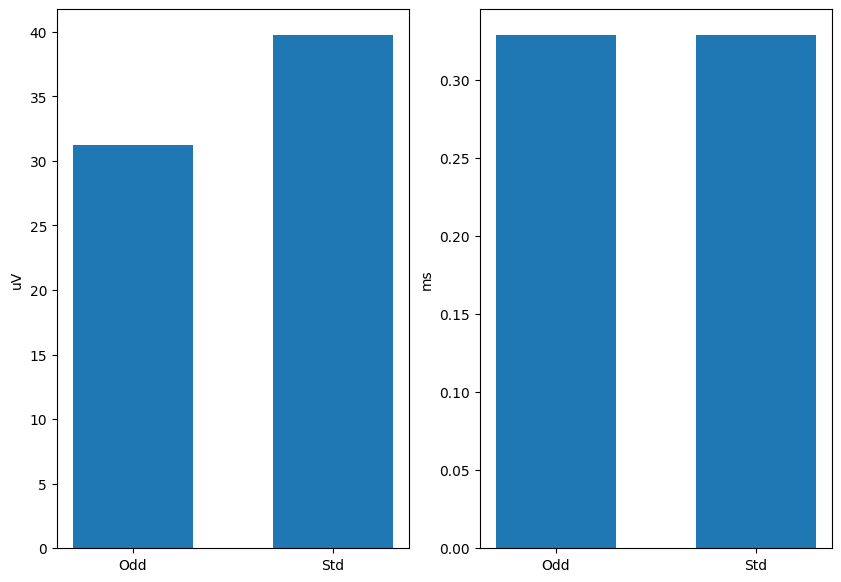

In [67]:
fig2, axs = plt.subplots(ncols=2)
fig2.set_figwidth(10)
fig2.set_figheight(7)


OddPeak=Odd_P300_single['amp'].mean()/10**-6
StdPeak=Std_P300_single['amp'].mean()/10**-6
Conds = ['Odd','Std']
Peaks=[OddPeak, StdPeak]
ax1=plt.subplot(1,2,1)
plt.bar(Conds, Peaks,width=0.6)
ax1.set_ylabel('uV')


OddPeak=Odd_P300_single['lat'].mean()
StdPeak=Std_P300_single['lat'].mean()
Conds = ['Odd','Std']
Peaks=[OddPeak, StdPeak]
ax2=plt.subplot(1,2,2)
plt.bar( Conds, Peaks, width=0.6)
ax2.set_ylabel('ms')


* 2.3 Quantify and compare the difference between Odd and Std

In [69]:
# However, to visualize the contrast of Odd vs Std, the epoch, raw dataset should be concatenated.
# I decided to output all the epoch of each recording:

df=pd.read_parquet(Runs[0])
raw0_filtered=PreprocessingEEG(df, (51.5, 68.1,103), 0.5, 30)
epochs0 =Get_Evoke(df,256, raw_filtered,event_id, MaxEventValue=5, tmin=-0.2, tmax=0.6) # The epoch of the first recording...etc

df=pd.read_parquet(Runs[1])
raw1_filtered=PreprocessingEEG(df, (51.5, 68.1,103), 0.5, 30)
epochs1=Get_Evoke(df,256, raw_filtered, event_id, MaxEventValue=5, tmin=-0.2, tmax=0.6)

df=pd.read_parquet(Runs[2])
raw2_filtered=PreprocessingEEG(df, (51.5, 68.1,103), 0.5, 30)
epochs2=Get_Evoke(df,256, raw_filtered, event_id, MaxEventValue=5, tmin=-0.2, tmax=0.6)

# The three recordings are merged. 
AllEEG=mne.concatenate_raws([raw0_filtered, raw1_filtered, raw2_filtered])

# The grand averagde of Odd and Std condition across recordings.
Epochs_Odd=mne.concatenate_epochs([epochs0[0]['Odd'], epochs1[0]['Odd'], epochs2[0]['Odd']])
Epochs_Std=mne.concatenate_epochs([epochs0[0]['Std'], epochs1[0]['Std'], epochs2[0]['Std']])

Creating RawArray with float64 data, n_channels=4, n_times=95528
    Range : 0 ... 95527 =      0.000 ...   373.152 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1691 samples (6.605 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Uppe

combining channels using "mean"
combining channels using "mean"


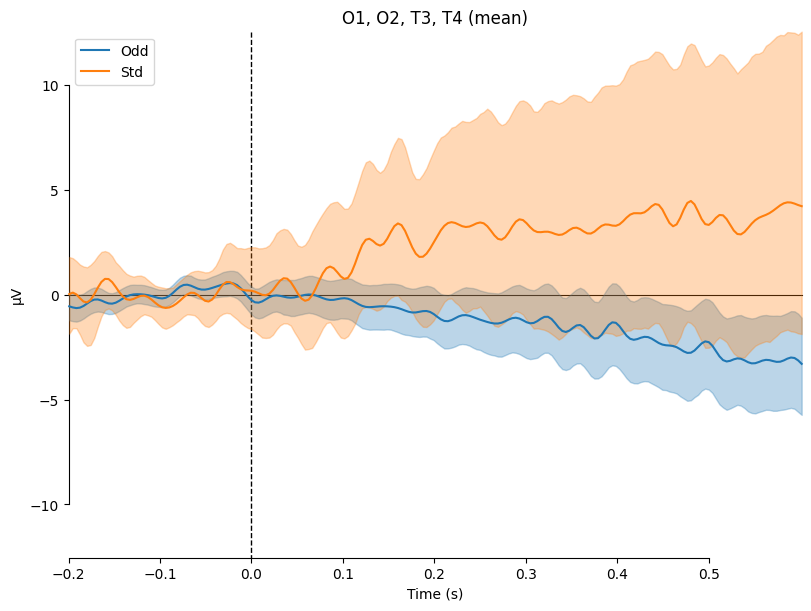

Could not find a adjacency matrix for the data. Computing adjacency based on Delaunay triangulations.
-- number of adjacent vertices : 4
stat_fun(H1): min=0.000004 max=7.633871
Running initial clustering …
Using 75 thresholds from 0.20 to 7.60 for TFCE computation (h_power=2.00, e_power=0.50)
Found 824 clusters


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

105 points selected by TFCE ...
No projector specified for this dataset. Please consider the method self.add_proj.


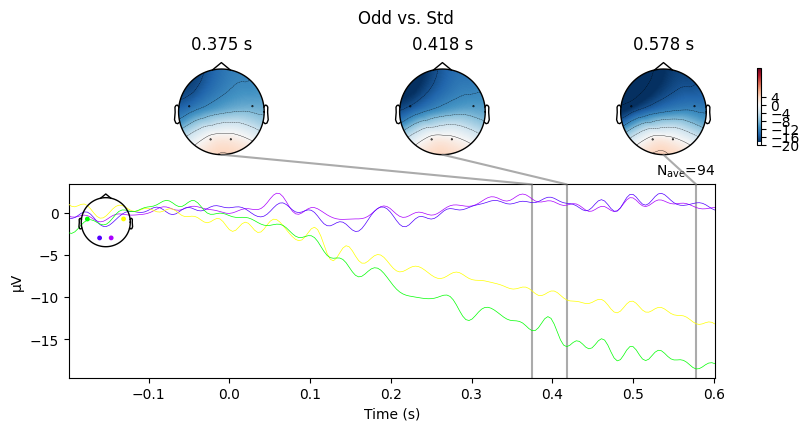

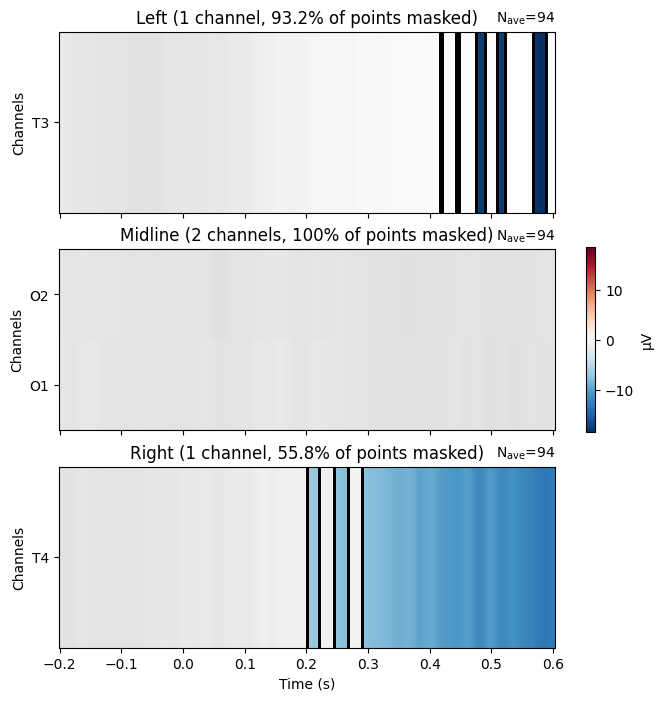

In [73]:
# Odd vs Std are plotted and compared in the time domain
# The time point showing significant difference will be picked and displayed 
# in the time-domain map.

Contrast(Epochs_Odd, Epochs_Std)

*2.4 T-Test of the peak of Odd vs Std acorss three timy windows

In [72]:
MiniTimeWindows=[[0.25, 0.3], [0.3, 0.35], [0.35, 0.4]]

ttest=ttest_TimeInterval(AllEEG, EvokeWindow, MiniTimeWindows)

Not setting metadata
1 matching events found
Setting baseline interval to [-0.19921875, 0.0] s
Applying baseline correction (mode: mean)


0 projection items activated
Not setting metadata
1 matching events found
Setting baseline interval to [-0.19921875, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Not setting metadata
1 matching events found
Setting baseline interval to [-0.19921875, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Not setting metadata
1 matching events found
Setting baseline interval to [-0.19921875, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Not setting metadata
1 matching events found
Setting baseline interval to [-0.19921875, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Not setting metadata
1 matching events found
Setting baseline interval to [-0.19921875, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Not setting metadata
1 matching events found
Setting baseline interval to [-0.19921875, 0.0] s
Applying baseline correction (mode: mean)
0 pr

In [107]:
#Caculate the t-test within each mini time windows with 50ms interval
#However, if we run the within subject comparison, there is no significant 
# difference between the two conditions in all the three time window
# What can be improve is to set an mini time interval and quantify the mean amplitude 
# instead of choosing the peak. 

from scipy.stats import ttest_ind
Channel_name=AllEEG.info.ch_names
time_windows = [[0.25, 0.3], [0.3, 0.35], [0.35, 0.4]]
#elec=AllEEG.info.ch_names

report = "{elec}, time: {tmin}-{tmax} s; t({df})={t_val:.3f}, p={p:.3f}"
#report = "{elec}, time: {tmin}-{tmax} s; t={t_val:.3f}, p={p:.3f}"

tvalue=[]
pvalue=[]
channel=[]
timeinterval=[]

for i in time_windows:
    Odd_cropped=Get_ERP(AllEEG, 'Odd',[-0.2, 0.6], i , average=False)
    Std_cropped=Get_ERP(AllEEG, 'Std',[-0.2, 0.6], i , average=False)
    
    for elec in Channel_name:
        group1 = Odd_cropped['amp'].where(Odd_cropped.ch== elec).dropna()
        group2 = Std_cropped['amp'].where(Std_cropped.ch== elec).dropna()
        t, p =ttest_ind(group1,group2)
        
        # display results
        format_dict = dict(
            elec=elec, tmin=i[0], tmax=i[-1], #df=len(Epochs.events) - 2, 
            t_val=t, p=p
        )
        
        channel.append(elec)
        timeinterval.append(i)
        tvalue.append(t)
        pvalue.append(p)
        
Report=pd.DataFrame([channel, timeinterval,tvalue,pvalue]).transpose()    
Report.columns=['ChannelName','TimeInterval','t(df)','p-value']

Report

Not setting metadata
1 matching events found
Setting baseline interval to [-0.19921875, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Not setting metadata
1 matching events found
Setting baseline interval to [-0.19921875, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Not setting metadata
1 matching events found
Setting baseline interval to [-0.19921875, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Not setting metadata
1 matching events found
Setting baseline interval to [-0.19921875, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Not setting metadata
1 matching events found
Setting baseline interval to [-0.19921875, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Not setting metadata
1 matching events found
Setting baseline interval to [-0.19921875, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Not 

,ChannelName,TimeInterval,t(df),p-value
0,O1,"[0.25, 0.3]",0.587983,0.557491
1,O2,"[0.25, 0.3]",0.937941,0.349753
2,T3,"[0.25, 0.3]",0.142777,0.88667
3,T4,"[0.25, 0.3]",0.613176,0.540762
4,O1,"[0.3, 0.35]",-0.385388,0.700531
5,O2,"[0.3, 0.35]",0.818902,0.414133
6,T3,"[0.3, 0.35]",-0.023497,0.981286
7,T4,"[0.3, 0.35]",0.477027,0.634056
8,O1,"[0.35, 0.4]",0.423713,0.672403
9,O2,"[0.35, 0.4]",0.550803,0.582578


# Task 3 - EEG Processing - VEP EEG Data Description

* 3.0 Information of the EEG raw data

In [74]:
# Read the trials in the vep folder
VEPfilepath='/Users/tracy/Desktop/Neuroengineer-2024-main/EEG/eeg_data-3/vep/'
Runs = glob.glob(VEPfilepath+'*.parquet')
df=pd.read_parquet(Runs[0])
event_id={1:'Odd',2:'Std', 3: 'VEP'}
event_id=dict(Odd=1, Std=2, VEP=3) #, Resp1=10001, Resp2=1002, Resp3=1003, Resp4=1004) #Start=10000, End=10001)
sfreq=256
Channel_name=['O1','O2','T3','T4']

* 3.1 P100 processing

In [80]:
EvokeWindow=[-0.1, 0.3]
PeakInterval=[0.05, 0.2]


Odd_P100_single=pd.DataFrame([])
Std_P100_single=pd.DataFrame([])
Odd_P100_all=pd.DataFrame([])
Std_P100_all=pd.DataFrame([])

for i in range(len(Runs)):
    df=pd.read_parquet(Runs[i])
    raw_filtered=PreprocessingEEG(df, (51.5, 68.1,103), 0.5, 30) #Powerline removal and the hearbeats artifact removal 
    # Extract the peak of each individual event
    Odd_P100=Get_ERP(raw_filtered, 'Odd',EvokeWindow,PeakInterval, average=False)
    Std_P100=Get_ERP(raw_filtered, 'Std',EvokeWindow,PeakInterval, average=False)  
    
    # Extract the peak of the grand average      
    Odd_P100_avg=Get_ERP(raw_filtered, 'Odd',EvokeWindow,PeakInterval, average=True)
    Std_P100_avg=Get_ERP(raw_filtered, 'Std',EvokeWindow,PeakInterval, average=True)
        
    Odd_P100_single=pd.concat([Odd_P100_single, Odd_P100], axis=0)
    Std_P100_single=pd.concat([Std_P100_single, Std_P100], axis=0)
    
    Odd_P100_all=pd.concat([Odd_P100_all, Odd_P100_avg], axis=0)
    Std_P100_all=pd.concat([Odd_P100_all, Odd_P100_avg], axis=0)

Creating RawArray with float64 data, n_channels=4, n_times=87492
    Range : 0 ... 87491 =      0.000 ...   341.762 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1691 samples (6.605 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Uppe

In [86]:
# The dataframe of P300
# The nan values are assigned if the peak amplitude is negative
Odd_P100_single.dropna().groupby(['ch']).mean()
Std_P100_single.dropna().groupby(['ch']).mean()

,lat,amp
ch,,
O1,0.158906,0.000044
O2,0.143594,0.000043
T3,0.145952,0.000047
T4,0.152734,0.000058


In [82]:
Odd_P100_all.dropna()
Std_P100_all.dropna()

,ch,lat,amp
0,O1,0.050781,0.000004
1,O2,0.066406,0.000005
3,T4,0.054688,0.000006
2,T3,0.144531,0.000018
0,O1,0.132812,0.000014
1,O2,0.132812,0.000006
0,O1,0.132812,0.000014
1,O2,0.132812,0.000006


Text(0, 0.5, 'ms')

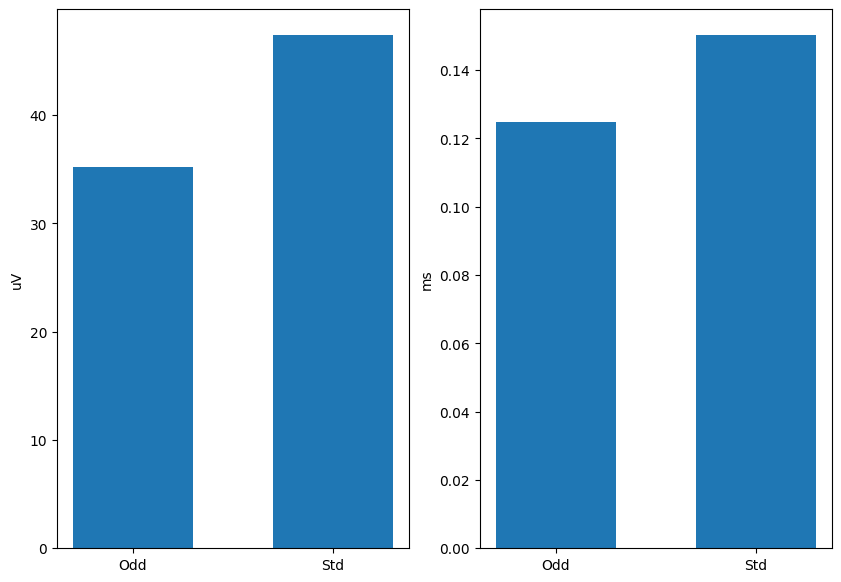

In [87]:
fig2, axs = plt.subplots(ncols=2)
fig2.set_figwidth(10)
fig2.set_figheight(7)


OddPeak=Odd_P100_single['amp'].mean()/10**-6
StdPeak=Std_P100_single['amp'].mean()/10**-6
Conds = ['Odd','Std']
Peaks=[OddPeak, StdPeak]
ax1=plt.subplot(1,2,1)
plt.bar(Conds, Peaks,width=0.6)
ax1.set_ylabel('uV')


OddPeak=Odd_P100_single['lat'].mean()
StdPeak=Std_P100_single['lat'].mean()
Conds = ['Odd','Std']
Peaks=[OddPeak, StdPeak]
ax2=plt.subplot(1,2,2)
plt.bar( Conds, Peaks, width=0.6)
ax2.set_ylabel('ms')


* 3.2 Compare bewteen Odd vs Std of P100 peak

In [90]:
# However, to visualize the contrast of Odd vs Std, the epoch, raw dataset should be concatenated.
# I decided to output all the epoch of each recording:

df=pd.read_parquet(Runs[0])
raw0_filtered=PreprocessingEEG(df, (51.5, 68.1,103), 0.5, 30)
epochs0 =Get_Evoke(df,256, raw_filtered, event_id,MaxEventValue=5, tmin=-0.1, tmax=0.3) # The epoch of the first recording...etc

df=pd.read_parquet(Runs[1])
raw1_filtered=PreprocessingEEG(df, (51.5, 68.1,103), 0.5, 30)
epochs1=Get_Evoke(df,256, raw_filtered,event_id,  MaxEventValue=5, tmin=-0.1, tmax=0.3)

df=pd.read_parquet(Runs[2])
raw2_filtered=PreprocessingEEG(df, (51.5, 68.1,103), 0.5, 30)
epochs2=Get_Evoke(df,256, raw_filtered, event_id, MaxEventValue=5, tmin=-0.1, tmax=0.3)

# The three recordings are merged. 
AllEEG=mne.concatenate_raws([raw0_filtered, raw1_filtered, raw2_filtered])

# The grand averagde of Odd and Std condition across recordings.
Epochs_Odd=mne.concatenate_epochs([epochs0[0]['Odd'], epochs1[0]['Odd'], epochs2[0]['Odd']])
Epochs_Std=mne.concatenate_epochs([epochs0[0]['Std'], epochs1[0]['Std'], epochs2[0]['Std']])

Creating RawArray with float64 data, n_channels=4, n_times=87492
    Range : 0 ... 87491 =      0.000 ...   341.762 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1691 samples (6.605 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Uppe

combining channels using "mean"
combining channels using "mean"


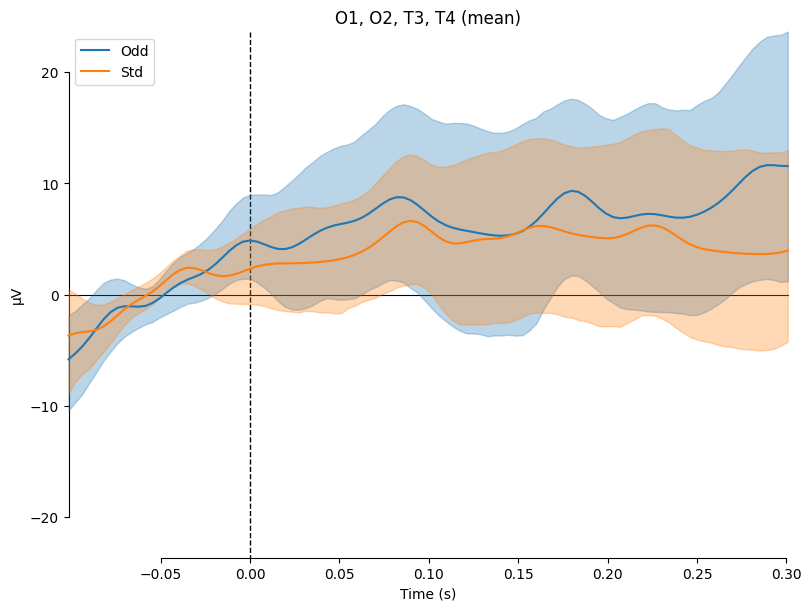

Could not find a adjacency matrix for the data. Computing adjacency based on Delaunay triangulations.
-- number of adjacent vertices : 4
stat_fun(H1): min=0.000000 max=3.991700
Running initial clustering …
Using 38 thresholds from 0.20 to 3.90 for TFCE computation (h_power=2.00, e_power=0.50)
Found 416 clusters


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

0 points selected by TFCE ...
No projector specified for this dataset. Please consider the method self.add_proj.


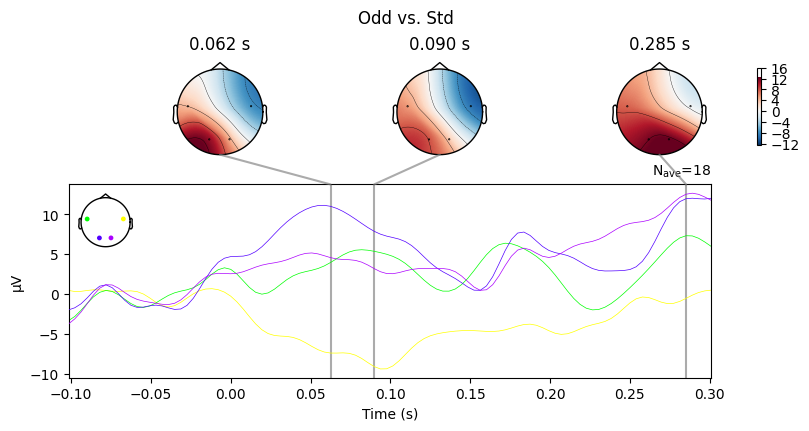

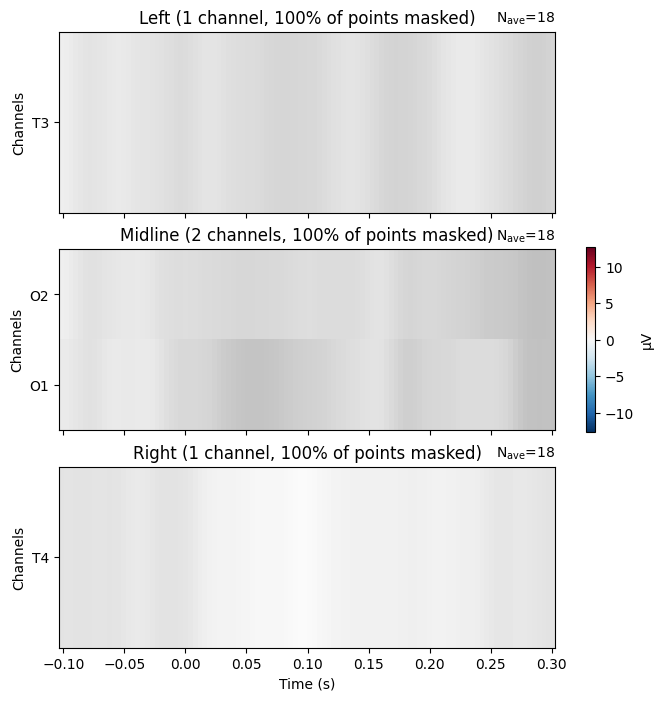

In [91]:
Contrast(Epochs_Odd, Epochs_Std)

* 3.3 T-Test of Odd vs Std in terms of three different tiny intervals

In [95]:
MiniTimeWindows=[[0.05, 0.1], [0.1, 0.15], [0.15, 0.2]]

ttest_TimeInterval(AllEEG, EvokeWindow, MiniTimeWindows)

Not setting metadata
1 matching events found
Setting baseline interval to [-0.1015625, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Not setting metadata
1 matching events found
Setting baseline interval to [-0.1015625, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Not setting metadata
1 matching events found
Setting baseline interval to [-0.1015625, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Not setting metadata
1 matching events found
Setting baseline interval to [-0.1015625, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Not setting metadata
1 matching events found
Setting baseline interval to [-0.1015625, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Not setting metadata
1 matching events found
Setting baseline interval to [-0.1015625, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Not settin

,ChannelName,TimeInterval,t(df),p-value
0,O1,"[0.05, 0.1]",-1.585081,0.144031
1,O2,"[0.05, 0.1]",-0.098323,0.923831
2,T3,"[0.05, 0.1]",-0.131283,0.89844
3,T4,"[0.05, 0.1]",-0.601924,0.558427
4,O1,"[0.1, 0.15]",-3.206026,0.007548
5,O2,"[0.1, 0.15]",-0.254378,0.80492
6,T3,"[0.1, 0.15]",0.621924,0.5537
7,T4,"[0.1, 0.15]",-0.409356,0.688472
8,O1,"[0.15, 0.2]",-0.34225,0.74098
9,O2,"[0.15, 0.2]",-2.140191,0.064757
